In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import osmnx as ox
import networkx as nx
import datetime
from saferoutesite.SQLRequest3 import Regression_List 
from saferoutesite.current_weather import get_current_weather
from saferoutesite.dijkstra_path1 import (get_bounding_box,
get_graph, edge_to_latlon_pair, get_path, haversine)

In [2]:
def go(args):
    '''
    Pull data from the crime database and weather information in order to 
    compute the safety score dictionary and runs all previous code in 
    order to find the safest route from start_address to end_address.
    
    Inputs:
    {args} containing:
      start_address (string): the starting point in the route
      end_address (string): the destination of the route
      date (string): the desired date if provided
      hour (int): the time of day if provided
      temp (int): temperature if provided
      precip (int): precipitation (inches) if provided

    
    Outputs:
      (list of lists of floats): the safest path in terms of (lat,lon)
      coordinates
    '''

    start_address = args["start_address"]
    end_address = args["end_address"]
    date = args["date_of_travel"]
    hour = args["hour_of_travel"]
    temp = args["temperature"]
    precip = args["precipitation"]

    current_DT = datetime.datetime.now()
    # handle optional args and set to defaults if necessary
    if not date:
        date = current_DT.strftime('%Y-%m-%d') 
    if not hour:
        hour = current_DT.hour
    current_temp, current_precip = get_current_weather()
    if not temp:
        temp = current_temp
    if not precip:
        precip = current_precip
    #start_coord, end_coord = get_coordinates(start_address, end_address)
    start_coord, end_coord = random_coords()

    if not start_coord or not end_coord:
        return "Please enter valid addresses within the City of Chicago."

    n_lat, s_lat, e_lon, w_lon = get_bounding_box(start_coord, end_coord)
    G = get_graph(n_lat, s_lat, e_lon, w_lon)
    nodes = list(G.nodes(data = True))
    edges = [(start, end, attrs) for (start, end, attrs) in G.edges(data = True)\
             if 'name' in attrs.keys()]
    node_dic = dict(G.nodes(data = True))
    edges_lst = [edge_to_latlon_pair(G, edge) for edge in edges]

    # adjust temperature and time sensitivities
    t_sens = 12
    p_sens = 0.5
    time_low = hour - 2
    time_up = hour + 2
    scores = Regression_List(edges_lst, temp, precip, t_sens, p_sens, date,\
                             time_low, time_up)
    
    path, s_length = get_path(start_coord, end_coord, G, nodes, scores)
    
    route_steps = [[G.nodes[node]['y'],G.nodes[node]['x']] for node in path]
    path_coords = [[start_coord[0],start_coord[1]]] + route_steps +\
                  [[end_coord[0],end_coord[1]]]

    if type(s_length) == dict:
        s_length = s_length[end_node]
    return s_length,haversine(start_coord, end_coord)

In [3]:
def random_coords():
    '''
    Gives random coordinates in the approximate vicinity of chicago.
    Coordinates are on average 5km apart. 
    '''
    lat1 = np.random.uniform(low=41.653530, high=42.019225)
    lon1 = np.random.uniform(low=-87.803654, high=-87.524710)
    len_ = 0.05 
    lat2 = np.random.uniform(low=max(41.653530, lat1-len_), high=min(42.019225, lat1+len_))
    lon2 = np.random.uniform(low=max(-87.803654, lon1-len_), high=min(-87.524710, lon1+len_))
    return (lat1, lon1),(lat2, lon2)

def random_temp():
    '''
    Give random temperature in degrees Farenheit.
    Appropriate for average of Chicago
    '''
    #mean temperature of Chicago is 49.5
    return np.random.normal(49.5, 30)

def random_hour():
    '''
    Gives random number between 0 and 24  
    '''
    return int(np.random.uniform(0, 24))

#From PA3
def haversine(t1, t2):
    '''
    Calculate the circle distance between two points
    on the earth (specified in decimal degrees)
    '''
    lat1, lon1 = t1
    lat2, lon2 = t2
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    # 6367 km is the radius of the Earth
    km = 6367 * c
    m = km * 1000
    return m

#From Stack Overflow Question 8747761
def lognorm(x,mu=0,sigma=1):
    ''' 
    gives result of cdf of lognorm given mu/sigma
    '''
    a = (math.log(x) - mu)/math.sqrt(2*sigma**2)
    p = 0.5 + 0.5*math.erf(a)
    return p



In [10]:
#Generating random sample 
s_lst = []
for i in range(500):
    try:
        ret = go({
              'start_address': None,
              'end_address': None,
              'date_of_travel': '2019-03-16',
              'hour_of_travel': random_hour(),
              'temperature': random_temp(),
              'precipitation': 0})
    #Accounts for the potential of random_coords returning
    #coordinates not in chicago or identically located, etc. 
    except:
        continue 
    s_lst.append(ret[0]/ret[1])

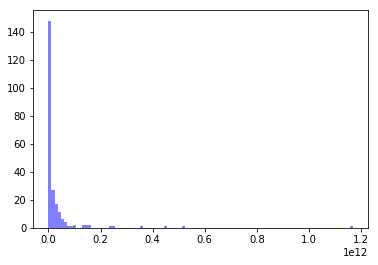

In [29]:
#Data Visualization
plt.hist(s_lst, 100, facecolor='blue', alpha=0.5)
plt.show()

In [30]:
#Estimating distribution
shape, loc, scale = stats.lognorm.fit(s_lst, floc=0)

In [31]:
#Result of distribution
shape, loc, scale

(10.433836709999136, 0.0, 893840.8440044996)